# Coarse-graining done properly

$$
    \bar{\psi}(\vec{x}) = \int \mathrm{d} \vec{r} ~ K(\vec{x}, \vec{x} - \vec{r}) \psi(\vec{r})
$$

Current issues:
- Coarse-graining does not commute with differentiation because the filter kernel is inhomogeneous
    - Therefore coarse-graining violates mass continuity
- The coarse-grained fields are not well-resolved on the coarse grid
    - This makes the tendencies noisy and unpredictable
- Coarse-graining violates the no-slip and isothermal boundary conditions at $z=0,1$

Solutions:
- Use a homogeneous Gaussian filter
    - The homogeneity of the filter at the boundaries is ensured by extending the flow past the boundary (Bae and Lozano-Durán 2017; see below)
    - This is difficult to implement when the grid has non-constant vertical spacing so I will first upsample the fields vertically onto a regular grid by interpolation
    - The interpolation is performed using the Chebyshev spectral functions, so there is no additional error
    - To minimise loss of information, the spacing of the upsampled grid is half the average spacing of the original grid
- The width of the filter will be larger than one coarse grid box
- Following the method of Bae and Lozano-Durán (2017), the boundary conditions are preserved by extending the flow below $z=0$ and above $z=1$ such that
    $$
    \begin{align}
        u(-z) &= -u(z), & w(-z) &= w(z), & \theta(-z) &= 1 - \theta(z) \\
        u(1+z) &= -u(1-z), & w(1+z) &= w(1-z), & \theta(1+z) &= -1 - \theta(1-z)
    \end{align}
    $$
    This ensures that the filtering preserves $u(z=0,1) = 0$, $\theta(z=0) = 1/2$ and $\theta(z=1) = -1/2$. On the other hand, it preserves $\partial w/\partial z |_{z=0,1} = 0$ but not necessarily $w(z=0,1) = 0$. This is necessary to preserve incompressibility.

In [309]:
import importlib

import xarray as xr
import matplotlib.pyplot as plt
import dedalus.public as d3
import numpy as np
import scipy as sp

from modules import regridding
from modules import spatial
importlib.reload(spatial)

<module 'modules.spatial' from '/srv/ccrc/AtmSS/z5310829/honours_project/modules/spatial.py'>

## Example data

In [128]:
data = xr.open_mfdataset('../data/training/2048x256_t/*.nc')
data = data.theta.isel(t=-1).compute()
theta = data.data
x = data.x.data
z = data.z.data

[None]

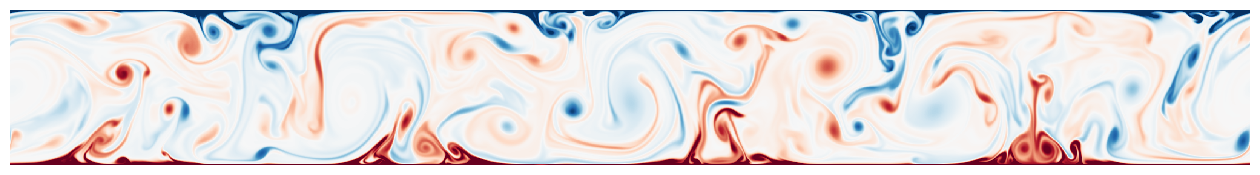

In [129]:
fig, ax = plt.subplots(figsize=(16,3))
ax.pcolormesh(x, z, theta.T, cmap='RdBu_r', vmin=-0.2, vmax=0.2)
ax.axis('off')
ax.set(aspect='equal')

## Upsampling

In [141]:
aspect = 8
Nx = x.size
Nz = z.size
coords = d3.CartesianCoordinates('x', 'z')
dist = d3.Distributor(coords, dtype=np.float64)
xbasis = d3.RealFourier(coords['x'], size=Nx, bounds=(0, aspect))
zbasis = d3.ChebyshevT(coords['z'], size=Nz, bounds=(0, 1))
field = dist.Field(bases=(xbasis, zbasis))

In [146]:
z_interp = np.linspace(0, 1, 2*z.size)
theta_interp = np.zeros((x.size, z_interp.size))

field['g'] = data.data
for i, pos in enumerate(z_interp):
    theta_interp[:,i] = field(z=pos).evaluate()['g'].squeeze()

[None]

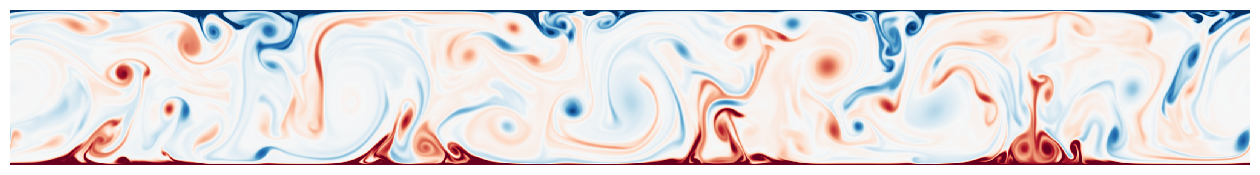

In [149]:
fig, ax = plt.subplots(figsize=(16,3))
ax.pcolormesh(x, z_interp, theta_interp.T, cmap='RdBu_r', vmin=-0.2, vmax=0.2)
ax.axis('off')
ax.set(aspect='equal')

## Extension

In [264]:
std = 8/256
truncate = 4.0
dx = x[1] - x[0]
dz = z_interp[1] - z_interp[0]

# number of grid points corresponding to 1 standard deviation
std_x = std/dx
std_z = std/dz

# truncation lengths
truncate_x = truncate*std_x
truncate_z = truncate*std_z

# extension lengths
extend_x = int(np.ceil(truncate_x))
extend_z = int(np.ceil(truncate_z))

theta_ext = theta_interp.copy()
# perform x extension
theta_ext = np.concatenate([
    theta_ext[-extend_x:,:],
    theta_ext,
    theta_ext[:extend_x,:],
], axis=0)
x_ext = np.concatenate([
    np.arange(-extend_x*dx, 0, dx),
    x,
    np.arange(aspect, aspect + extend_x*dx, dx),
])

# perform z extension
theta_ext = np.concatenate([
    1 - theta_ext[:, extend_z:0:-1],
    theta_ext,
    -1 - theta_ext[:, -2:-(extend_z+2):-1],
], axis=1)
z_ext = np.concatenate([
    np.arange(-extend_z*dz, 0, dz),
    z_interp,
    np.arange(1 + dz, 1 + (extend_z+1)*dz, dz),
])

[None]

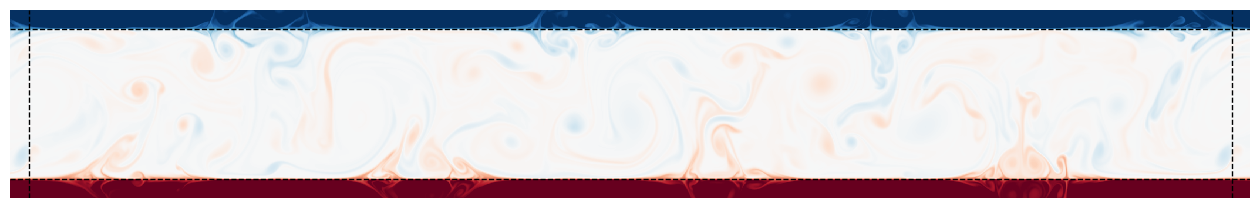

In [347]:
fig, ax = plt.subplots(figsize=(16,3))
ax.pcolormesh(x_ext, z_ext, theta_ext.T, cmap='RdBu_r', vmin=-0.9, vmax=0.9)
ax.axvline(0, color='k', linestyle='--', linewidth=1)
ax.axvline(8, color='k', linestyle='--', linewidth=1)
ax.axhline(0, color='k', linestyle='--', linewidth=1)
ax.axhline(1, color='k', linestyle='--', linewidth=1)
ax.axis('off')
ax.set(aspect='equal')

## Filtering

In [266]:
theta_filt = sp.ndimage.gaussian_filter(
    theta_ext, sigma=(std_x, std_z), truncate=truncate)

[None]

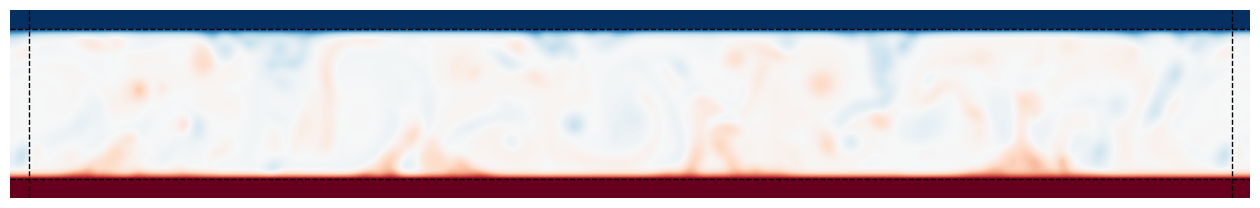

In [267]:
fig, ax = plt.subplots(figsize=(16,3))
ax.pcolormesh(x_ext, z_ext, theta_filt.T, cmap='RdBu_r', vmin=-0.5, vmax=0.5)
ax.axvline(0, color='k', linestyle='--', linewidth=1)
ax.axvline(8, color='k', linestyle='--', linewidth=1)
ax.axhline(0, color='k', linestyle='--', linewidth=1)
ax.axhline(1, color='k', linestyle='--', linewidth=1)
ax.axis('off')
ax.set(aspect='equal')

## Truncation and downsampling

In [268]:
theta_trunc = theta_filt[extend_x:-extend_x, extend_z:-extend_z]

In [269]:
xbasis_sub = d3.RealFourier(coords['x'], size=256, bounds=(0, aspect))
zbasis_sub = d3.ChebyshevT(coords['z'], size=32, bounds=(0, 1))
x_sub = xbasis_sub.global_grid().squeeze()
z_sub = zbasis_sub.global_grid().squeeze()

x_sampler = sp.interpolate.interp1d(x, theta_trunc, axis=0)
theta_sub = x_sampler(x_sub)
z_sampler = sp.interpolate.interp1d(z_interp, theta_sub, axis=1)
theta_sub = z_sampler(z_sub)

[None]

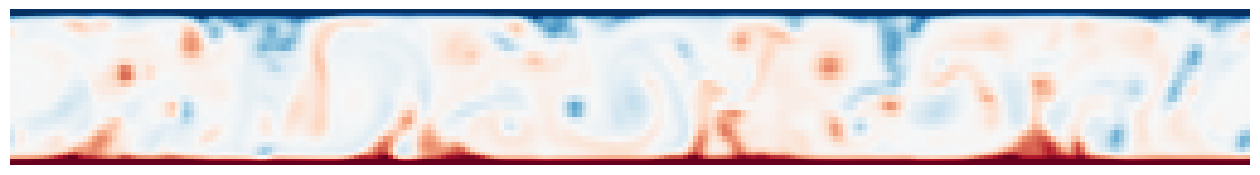

In [270]:
fig, ax = plt.subplots(figsize=(16,3))
ax.pcolormesh(x_sub, z_sub, theta_sub.T, cmap='RdBu_r', vmin=-0.2, vmax=0.2)
ax.axis('off')
ax.set(aspect='equal')

## Final comparison

In [315]:
data = xr.open_mfdataset('../data/training/2048x256_t/*.nc')
data = data.isel(t=-1).compute()

regridder = regridding.Regridder(
    source=data, target={'x': x_sub, 'z': z_sub},
    limits={'z': (0, 1)}, periods={'x': 8}
)
data_regrid = regridder(data)

filter = spatial.Filter((2048, 256), (256, 32), 8)
data_filt = filter(data, 1/32)

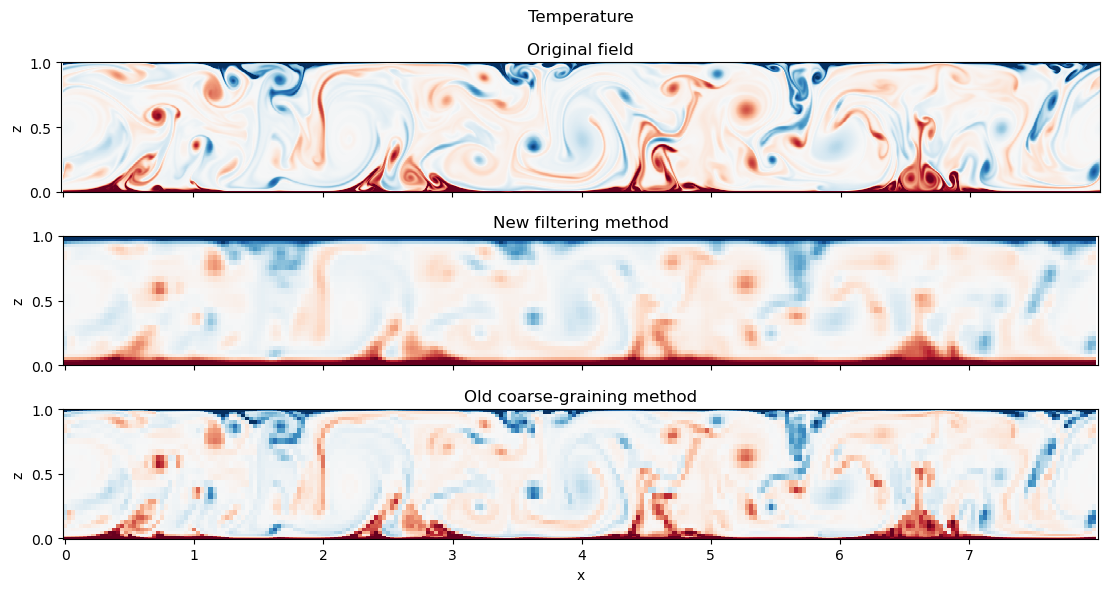

In [321]:
fig, axes = plt.subplots(3, 1, figsize=(16,6), sharex=True)

axes[0].pcolormesh(
    x, z, data.theta.T, cmap='RdBu_r', vmin=-0.2, vmax=0.2)
axes[0].set(aspect='equal', title='Original field', ylabel='z')

axes[1].pcolormesh(
    x_sub, z_sub, data_filt.theta.T, cmap='RdBu_r', vmin=-0.2, vmax=0.2)
axes[1].set(aspect='equal', title='New filtering method', ylabel='z')

axes[2].pcolormesh(
    x_sub, z_sub, data_regrid.theta, cmap='RdBu_r', vmin=-0.2, vmax=0.2)
axes[2].set(
    aspect='equal', title='Old coarse-graining method', xlabel='x', ylabel='z')

fig.suptitle('Temperature')
fig.tight_layout()

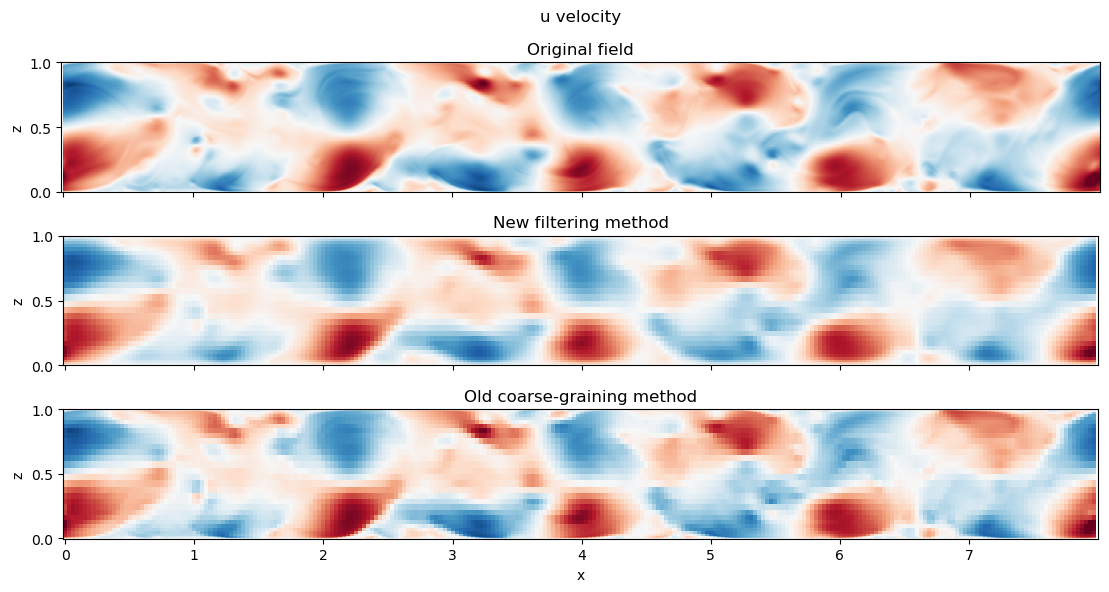

In [325]:
fig, axes = plt.subplots(3, 1, figsize=(16,6), sharex=True)

axes[0].pcolormesh(
    x, z, data.u.T, cmap='RdBu_r', vmin=-0.8, vmax=0.8)
axes[0].set(aspect='equal', title='Original field', ylabel='z')

axes[1].pcolormesh(
    x_sub, z_sub, data_filt.u.T, cmap='RdBu_r', vmin=-0.8, vmax=0.8)
axes[1].set(aspect='equal', title='New filtering method', ylabel='z')

axes[2].pcolormesh(
    x_sub, z_sub, data_regrid.u, cmap='RdBu_r', vmin=-0.8, vmax=0.8)
axes[2].set(
    aspect='equal', title='Old coarse-graining method', xlabel='x', ylabel='z')

fig.suptitle('u velocity')
fig.tight_layout()

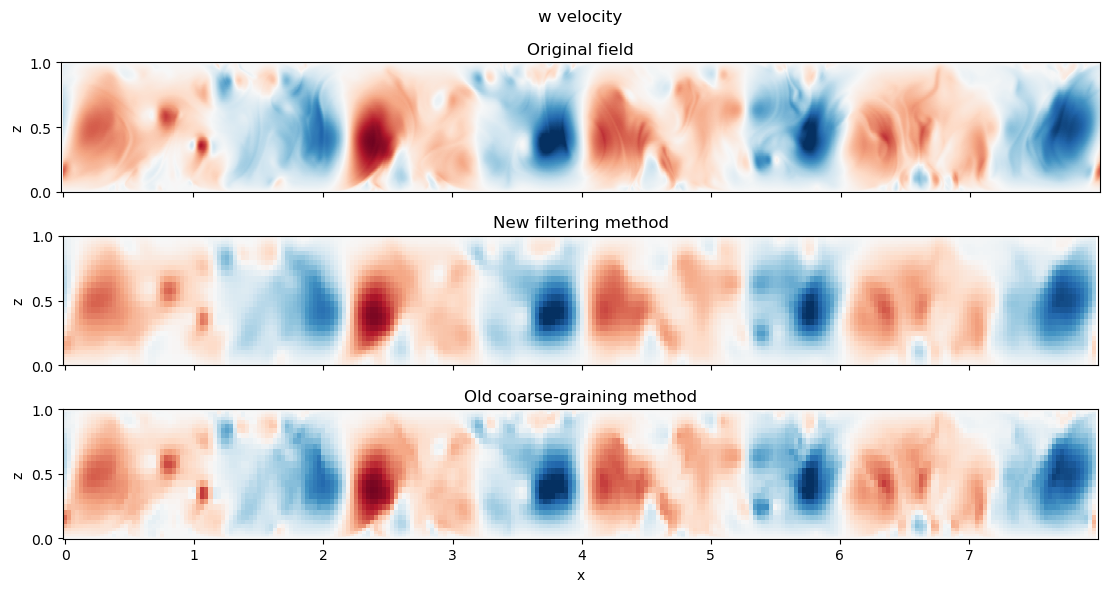

In [327]:
fig, axes = plt.subplots(3, 1, figsize=(16,6), sharex=True)

axes[0].pcolormesh(
    x, z, data.w.T, cmap='RdBu_r', vmin=-0.9, vmax=0.9)
axes[0].set(aspect='equal', title='Original field', ylabel='z')

axes[1].pcolormesh(
    x_sub, z_sub, data_filt.w.T, cmap='RdBu_r', vmin=-0.9, vmax=0.9)
axes[1].set(aspect='equal', title='New filtering method', ylabel='z')

axes[2].pcolormesh(
    x_sub, z_sub, data_regrid.w, cmap='RdBu_r', vmin=-0.9, vmax=0.9)
axes[2].set(
    aspect='equal', title='Old coarse-graining method', xlabel='x', ylabel='z')

fig.suptitle('w velocity')
fig.tight_layout()

## (hopefully) minor issue: vertical velocity not exactly zero at $z=0,1$

[Text(0.5, 0, 'x'), Text(0, 0.5, 'w(z=0)')]

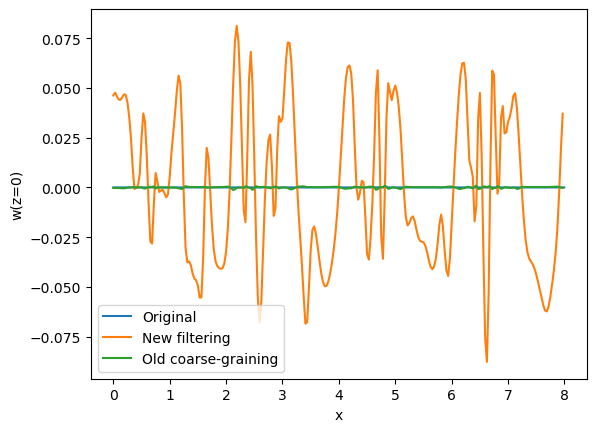

In [346]:
fig, ax = plt.subplots()
ax.plot(
    data.x, data.w.interp({'z': 0}, kwargs={'fill_value': 'extrapolate'}),
    label='Original',
)
ax.plot(
    data_filt.x,
    data_filt.w.interp({'z': 0}, kwargs={'fill_value': 'extrapolate'}),
    label='New filtering',
)
ax.plot(
    data_regrid.x,
    data_regrid.w.interp({'z': 0}, kwargs={'fill_value': 'extrapolate'}),
    label='Old coarse-graining',
)
ax.legend()
ax.set(xlabel='x', ylabel='w(z=0)')